## CIRCUIT ANALYSIS
In this notebook, we perform an analysis on Formula 1 racing data to identify circuits where drivers typically experience the least and the most position changes between their starting and finishing positions.

it reads datasets containing lap times, pit stops, race details, and circuit information. 
Then, it filters the data to consider races held after a specific race ID ( 841 or higher race ID indicates the races after 2011 )  and ensures that only circuits with at least 10 races are included. The code calculates the position changes for each driver from their starting to finishing positions in each race, averages these changes per circuit, and identifies the circuits with the lowest average position changes. Finally, it visualizes the results using a horizontal bar chart, where circuits are ranked based on the average position differences, with colors indicating whether the position change is below or above the median. This analysis aims to highlight circuits where the overtaking on the racetrack is particularly harder than other circuits 

In [35]:
import pandas as pd

lap_times_df = pd.read_csv('Dataset/lap_times.csv')
pit_stops_df = pd.read_csv('Dataset/pit_stops.csv')
races_df     = pd.read_csv('Dataset/races.csv')
circuits_df  = pd.read_csv('Dataset/circuits.csv')


In [36]:
lap_times_df  = lap_times_df.query('raceId >= 841')
pit_stops_df  = pit_stops_df.query('raceId >= 841')

races_df      = races_df.query('raceId>= 841')

In [37]:
circuit_race_counts = races_df.groupby('circuitId').size().reset_index(name='race_count')
circuits_with_min_5_races = circuit_race_counts[circuit_race_counts['race_count'] >= 10]
circuits_with_min_5_races_named = pd.merge(circuits_with_min_5_races, circuits_df[['circuitId', 'name']], on='circuitId', how='left')


In [38]:
for row in races_df.index.values:    
    if not races_df.loc[row]['circuitId'] in circuits_with_min_5_races_named['circuitId']:
        races_df.drop(index = row, axis=1, inplace=True)

In [39]:
first_laps = lap_times_df.groupby(['raceId', 'driverId'])['lap'].min().reset_index()
last_laps = lap_times_df.groupby(['raceId', 'driverId'])['lap'].max().reset_index()


first_lap_positions = pd.merge(first_laps, lap_times_df, on=['raceId', 'driverId', 'lap'], how='left')
last_lap_positions = pd.merge(last_laps, lap_times_df, on=['raceId', 'driverId', 'lap'], how='left')


position_changes = pd.merge(first_lap_positions[['raceId', 'driverId', 'position']],
                            last_lap_positions[['raceId', 'driverId', 'position']],
                            on=['raceId', 'driverId'], suffixes=('_start', '_finish'))


position_changes['position_change'] = abs(position_changes['position_finish'] - position_changes['position_start'])

race_circuit_mapping = races_df[['raceId', 'circuitId']]
position_changes_with_circuit = pd.merge(position_changes, race_circuit_mapping, on='raceId', how='left')
average_position_changes_per_circuit = position_changes_with_circuit.groupby('circuitId')['position_change'].mean().reset_index()

average_position_changes_per_circuit_sorted = average_position_changes_per_circuit.sort_values(by='position_change', ascending=True)

f_circuits = pd.merge(average_position_changes_per_circuit_sorted, circuits_df[['circuitId', 'name']], on='circuitId', how='left')[:10]


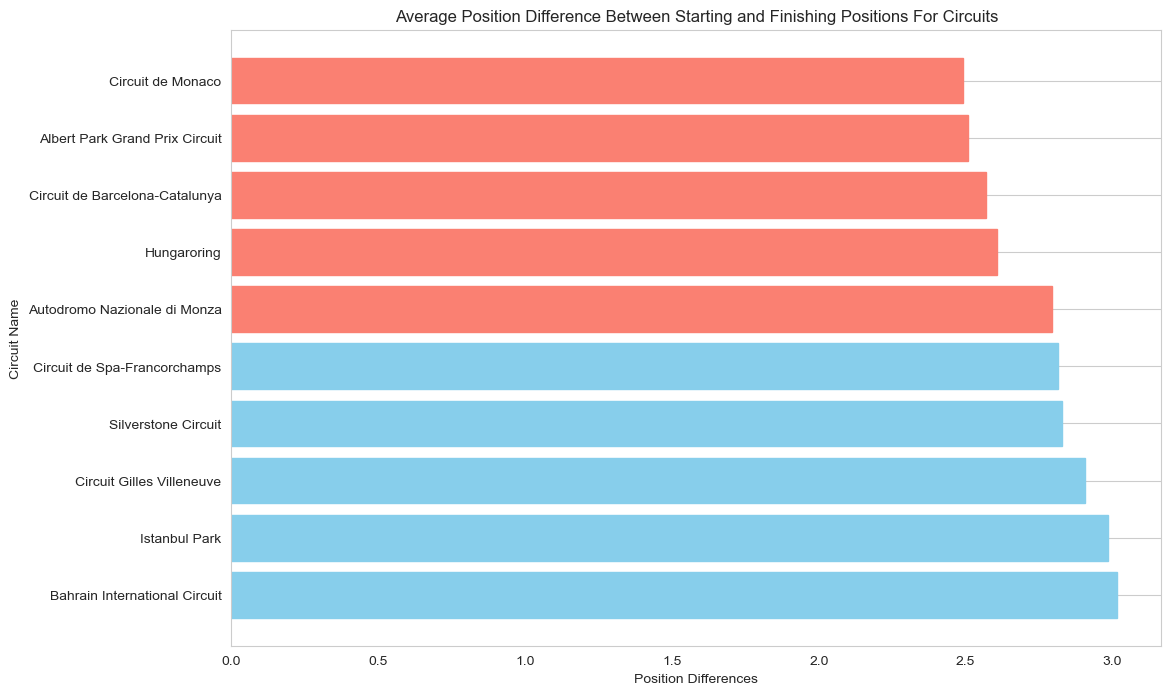

In [40]:
from matplotlib import pyplot as plt
import numpy as np

colors = np.where(f_circuits["position_change"] < f_circuits["position_change"].median(), 'salmon', 'skyblue')

plt.figure(figsize=(12, 8))
bars = plt.barh(f_circuits['name'], f_circuits['position_change'], color=colors)
plt.xlabel('Position Differences')
plt.ylabel('Circuit Name')
plt.title('Average Position Difference Between Starting and Finishing Positions For Circuits')
plt.gca().invert_yaxis() 
plt.grid(axis='x')

for bar, color in zip(bars, colors):
    bar.set_edgecolor(color)

plt.show()

There are 10 circuits displayed on the bar plot. We will continue our analyses for top 2 hardest tracks to take-over other cars. Namely, Circuit de Monaco and Albert Park Grand Prix Circuit. And the third selection of us will be Autodromo Nazionale di Monza because it has been one of the most iconic circuit in the history of F1 